In [1]:
from taxi import utils, taxi

In [2]:
import gc
import glob
import torch

import numpy as np
from datasets import load_dataset
from graspologic.embed import ClassicalMDS
from scipy.spatial.distance import pdist, squareform
from sentence_transformers import SentenceTransformer
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import (
    prepare_model_for_kbit_training,
    LoraConfig,
    get_peft_model,
    PeftModel,
    PeftConfig
)

EMBEDDING_MODEL = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True, device='cuda:0')

model_id = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    trust_remote_code=True
)
tokenizer.padding_token = tokenizer.eos_token
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side='right'


# group 1: Health (2), Sports (5), Family (8)
# group 2: Politics (9), business (6), society and culture (0)
# group 3: Computers (4), Entertainment (7), Education (3) 
coarse_to_fine_dict = {
    0: (2,5,8),
    1: (9,6,0),
    2: (4,7,3)
}

dataset_name = 'community-datasets/yahoo_answers_topics'
topic_key = 'topic'
cache_dir = '~/.cache/huggingface/datasets'

mc_model = 1
mc_variable = 20

N=10000

def get_fine_pis(coarse_pi, coarse_to_fine_dict):
    fine_topics = []
    fine_pi = []
    
    for i, coarse in enumerate(coarse_to_fine_dict):
        for fine in coarse_to_fine_dict[coarse]:
            fine_topics.append(fine)
            fine_pi.append(coarse_pi[coarse] / len(coarse_to_fine_dict[coarse]))
            
    return tuple(fine_topics), tuple(fine_pi)


<All keys matched successfully>


In [3]:
true_pi_list = [(1,0,0), (0,1,0), (0,0,1), (1/3,1/3,1/3)]
datasets = {}

for true_pi in true_pi_list:
    fine_topics, fine_pi = get_fine_pis(true_pi, coarse_to_fine_dict)
    datasets[true_pi] = utils.get_dataset_by_pi(fine_pi, dataset_name, topic_key, fine_topics, N, cache_dir=cache_dir, seed=0)

In [4]:
dist_pis = squareform(pdist(true_pi_list))
dist_pis /= np.linalg.norm(dist_pis)
true_geometry = ClassicalMDS(n_components=3).fit_transform(dist_pis)

data_geometry = taxi.get_dataset_geometry(true_geometry, 
                                          datasets, 
                                          EMBEDDING_MODEL
                                         )

In [5]:
query_pi = (1/3, 1/3, 1/3)

variable_list = [1*9,2*9, 5*9, 10*9,20*9, 50*9]
query_datasets = {}

fine_topics, fine_pi = get_fine_pis(query_pi, coarse_to_fine_dict)

for variable in variable_list:
    query_datasets[variable] = {}
    for i in range(mc_variable):
        query_datasets[variable][i] = utils.get_dataset_by_pi(fine_pi, dataset_name, topic_key, fine_topics, variable, cache_dir=cache_dir, seed=i)

In [6]:
lora_matrices = {}

for save_string in glob.glob('./models/N_10000*lora_128*'):
    print(save_string)

    # Extract true_pi from save_string
    pi_str = save_string.split('pi_')[-1]
    pi_values = [int(x)/100 for x in pi_str.split('_')]
    true_pi = tuple(pi_values)
    print(f"Extracted true_pi: {true_pi}")

    base_model = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype=torch.float16,
            device_map="cuda:0",
            trust_remote_code=True
    )


    model = PeftModel.from_pretrained(
        base_model,
        save_string,
        torch_dtype=torch.float16,
        device_map='cuda:0'
    )

    loras = taxi.get_lora_matrices(model, target_modules = ["q_proj","k_proj","v_proj"])
    lora_matrices[true_pi] = loras

    #clear memory
    del model
    del base_model
    torch.cuda.empty_cache()
    gc.collect()

structural_geometry = taxi.get_structural_geometry(true_geometry, lora_matrices)

./models/N_10000_lora_128_id_0_pi_000_000_100
Extracted true_pi: (0.0, 0.0, 1.0)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

./models/N_10000_lora_128_id_0_pi_000_100_000
Extracted true_pi: (0.0, 1.0, 0.0)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

./models/N_10000_lora_128_id_0_pi_033_033_033
Extracted true_pi: (0.33, 0.33, 0.33)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

./models/N_10000_lora_128_id_0_pi_100_000_000
Extracted true_pi: (1.0, 0.0, 0.0)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
from collections import defaultdict
func_behav = defaultdict(dict)
for save_string in glob.glob('./models/N_10000*lora_128*'):
    print('Model: ' , save_string)

    # Extract true_pi from save_string
    pi_str = save_string.split('pi_')[-1]
    pi_values = [int(x)/100 for x in pi_str.split('_')]
    true_pi = tuple(pi_values)

    base_model = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype=torch.float16,
            device_map="cuda:0",
            trust_remote_code=True
    )

    model = PeftModel.from_pretrained(
        base_model,
        save_string,
        torch_dtype=torch.float16,
        device_map='cuda:0'
    )

    for query_size in query_datasets:
        for (mc, query_dataset) in query_datasets[query_size].items():
            if mc not in func_behav[query_size]:
                func_behav[query_size][mc] = {}

            print('\tQuerying with: ', query_pi)
            query_strings = [q['question_title'] for q in query_dataset]
            responses, hidden_states = taxi.get_outputs(model, tokenizer, query_strings, max_length=32, match_n_input_tokens=True)
            func_behav[query_size][mc][true_pi] = {'responses': responses, 'hidden_states': hidden_states}

    del model
    del base_model
    torch.cuda.empty_cache()
    gc.collect()

Model:  ./models/N_10000_lora_128_id_0_pi_000_000_100


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)


/home/ubuntu/helivan-project-generation/venvs/helivan/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/home/ubuntu/helivan-project-generation/venvs/helivan/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/ubuntu/helivan-project-generation/venvs/helivan/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333333333333333)
	Querying with:  (0.3333333333333333, 0.3333333333333333, 0.3333

In [12]:
#func behav is [query_pi][training_pi]
functional_geometries_by_query_pi ={}
for variable in variable_list:
    functional_geometries_by_query_pi[variable] = {}
    for i in range(mc_variable):
        embeddings = {k: v['hidden_states'] for k,v in func_behav[variable][i].items()}
        functional_geometries_by_query_pi[variable][i] = taxi.get_functional_geometry(true_geometry, embeddings)

behaviorial_geometries_by_query_pi = {}
for variable in variable_list:
    behaviorial_geometries_by_query_pi[variable] = {}
    for i in range(mc_variable):
        responses = {k: v['responses'] for k,v in func_behav[variable][i].items()}
        behaviorial_geometries_by_query_pi[variable][i] = taxi.get_behavioral_geometry(true_geometry, responses, EMBEDDING_MODEL)

In [19]:
xs = []
data_ys = []
struct_ys = []
func_ys = []
behav_ys = []

for variable in variable_list:
    xs.append(variable)

    func_geo_dist = []
    behav_geo_dist = []
    for mc in range(mc_variable):
        #dataset geo dist
        data_geo_dist = np.linalg.norm(true_geometry - np.array(data_geometry))
    
        #structural geo dist
        struct_geo_dist = np.linalg.norm(true_geometry - np.array(structural_geometry))
    
        #functional geo dist
        func_geo_dist.append(np.linalg.norm(true_geometry - np.array(functional_geometries_by_query_pi[variable][mc])))
    
        #behaviorial geo dist
        behav_geo_dist.append(np.linalg.norm(true_geometry - np.array(behaviorial_geometries_by_query_pi[variable][mc])))

    data_ys.append(data_geo_dist)
    struct_ys.append(struct_geo_dist)
    func_ys.append(np.mean(func_geo_dist))
    behav_ys.append(np.mean(behav_geo_dist))

data_dict = {'x': xs, 'data': data_ys, 'structural': struct_ys, 'behavioral': behav_ys}
pickle.dump(data_dict, open('data/effect_of_size_of_q.p', 'wb'))

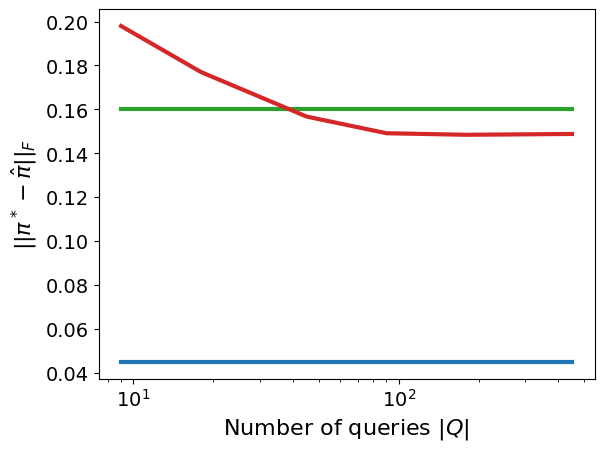

In [15]:
from matplotlib import pyplot as plt

plt.figure()
plt.xscale('log')
plt.ylabel('$||\pi^* - \hat \pi||_F$', fontsize=16)
plt.xlabel(r'Number of queries $|Q|$', fontsize=16)
plt.plot(xs, data_ys, label='data', lw=3, c='tab:blue')
plt.plot(xs, struct_ys, label='structural', lw=3, c='tab:green')
# plt.plot(xs, func_ys, label='func')
plt.plot(xs, behav_ys, label='behavioral', lw=3, color='tab:red')
# plt.legend(fontsize=12)
plt.tick_params(labelsize=14)
plt.show()

# plt.savefig('figures/effect_of_changing_q_distribution.pdf')